In [204]:
import numpy as np
from lxml import etree as ET
import pandas as pd
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import requests
import random
import tqdm
from concurrent.futures import ThreadPoolExecutor
import time
from scipy.optimize import fsolve

## Fetch the data from DBLP

In [2]:
def fetch_xml_from_url(url):
    try:
        response = requests.get(url)
        url1=response.url
        if response.status_code==429:
            retry_after = int(response.headers['Retry-After'])
            print('429 error, retry after', retry_after)
            time.sleep(retry_after+10)
            return fetch_xml_from_url(url)
        if response.status_code != 200:
            print('Error fetching xml from url')
            print("URL: ", url)
            print("Status code: ", response.status_code)
            #print("Response: ", response.content)
            return None
        if url1.endswith('.html'):
            url1=url1.replace('.html','.xml')
            return fetch_xml_from_url(url1)
        return ET.fromstring(response.content)
    except Exception as e:
        print(e)
        print('Error fetching xml from url')
        print("URL: ", url)
        print("Status code: ", response.status_code)
        #print("Response: ", response.content)
        return None
def is_disambiguation(xml):
    person_element = xml.find(".//person")
    if person_element is not None:
        publtype = person_element.get("publtype")
        return publtype == "disambiguation"
    return False

In [63]:
ori_data= pd.read_excel("DataScientists.xls")
ori_data

,name,country,institution,dblp,expertise
0,aaron elmore,united states,university of chicago,https://dblp.org/pers/e/Elmore:Aaron_J=.html,NaN
1,abdalghani abujabal,germany,amazon alexa,https://dblp.org/pers/a/Abujabal:Abdalghani.html,NaN
2,abdul quamar,united states,ibm research almaden,https://dblp.org/pers/q/Quamar:Abdul.html,NaN
3,abdulhakim qahtan,netherlands,utrecht university,https://dblp.org/pid/121/4198.html,NaN
4,abhijnan chakraborty,germany,max planck institute for software systems,https://dblp.org/pers/c/Chakraborty:Abhijnan.html,NaN
...,...,...,...,...,...
1215,zixian huang,china,nanjing university,https://dblp.uni-trier.de/pers/hd/h/Huang:Zixian,NaN
1216,zoi kaoudi,qatar,qatar computing research institute,https://dblp.org/pers/k/Kaoudi:Zoi.html,NaN
1217,zoi kaoudi,germany,tu berlin,https://dblp.org/pers/k/Kaoudi:Zoi.html,NaN
1218,zsolt istvan,germany,tu darmstadt,https://dblp.org/pid/50/10703.html,NaN


In [4]:
pids=[]
pid_xml={}
def single_xml(url):
    global pids,pid_xml
    if url.endswith('.html'):
        url=url.replace('.html','.xml')
    elif not url.endswith('.xml'):
        url=url+'.xml'
    xml=fetch_xml_from_url(url)
    if xml is not None:
        if not is_disambiguation(xml):
            pid=xml.xpath('//dblpperson')[0].attrib['pid']
            pids.append(pid)
            pid_xml[pid]=xml
        else:
            pids.append(None)
    else:
        pids.append(None)
processbar=tqdm.tqdm(total=ori_data.shape[0])
url_list=ori_data["dblp"].to_list()
for url in url_list:
    single_xml(url)
    processbar.update(1)

  0%|          | 6/1220 [00:05<19:27,  1.04it/s]

Error fetching xml from url
URL:  https://dblp.org/pid/39/1380.xml
Status code:  410


  5%|▍         | 56/1220 [01:01<25:06,  1.29s/it]

Error fetching xml from url
URL:  https://dblp.uni-trier.de/pers/c/Chakraborty:Anirban.xml
Status code:  410


 12%|█▏        | 148/1220 [02:41<18:34,  1.04s/it]

Error fetching xml from url
URL:  https://dblp.org/pid/92/2769.xml
Status code:  404


 12%|█▏        | 149/1220 [02:42<18:15,  1.02s/it]

Error fetching xml from url
URL:  https://dblp.org/pid/148/7268.xml
Status code:  410


 18%|█▊        | 214/1220 [03:59<20:29,  1.22s/it]

Error fetching xml from url
URL:  https://dblp.uni-trier.de/pers/b/Barbosa:Denilson.xml
Status code:  410


 18%|█▊        | 216/1220 [04:01<19:07,  1.14s/it]

Error fetching xml from url
URL:  https://dblp.org/pers/g/Georgakopoulos:Dimitrios.xml
Status code:  410


 18%|█▊        | 225/1220 [04:12<17:13,  1.04s/it]

Error fetching xml from url
URL:  https://dblp.org/pid/161/0102.xml
Status code:  410


 22%|██▏       | 263/1220 [04:52<13:54,  1.15it/s]

Error fetching xml from url
URL:  https://dblp.org/pers/m/Mansour:Essam.xml
Status code:  410


 22%|██▏       | 264/1220 [04:53<14:06,  1.13it/s]

Error fetching xml from url
URL:  https://dblp.org/pers/m/Mansour:Essam.xml
Status code:  410


 24%|██▎       | 289/1220 [05:23<17:08,  1.10s/it]

Error fetching xml from url
URL:  https://dblp.org/pid/284/0968.xml
Status code:  404


 30%|███       | 367/1220 [06:47<15:38,  1.10s/it]

Error fetching xml from url
URL:  https://dblp.org/pid/98/5721.xml
Status code:  410


 32%|███▏      | 392/1220 [07:12<13:53,  1.01s/it]

Error fetching xml from url
URL:  https://dblp.org/pers/j/Jung:Hyungsoo.xml
Status code:  410


 32%|███▏      | 396/1220 [07:17<15:12,  1.11s/it]

Error fetching xml from url
URL:  https://dblp.uni-trier.de/pers/p/Petrov:Ilia.xml
Status code:  410


 33%|███▎      | 397/1220 [07:18<14:05,  1.03s/it]

Error fetching xml from url
URL:  https://dblp.uni-trier.de/pers/p/Petrov:Ilia.xml
Status code:  410


 42%|████▏     | 511/1220 [09:39<11:02,  1.07it/s]

Error fetching xml from url
URL:  https://dblp.org/pers/h/Hui:Kai.xml
Status code:  410


 52%|█████▏    | 631/1220 [12:08<09:29,  1.03it/s]

Error fetching xml from url
URL:  https://dblp.org/pers/w/Weidlich:Matthias.xml
Status code:  410


 55%|█████▍    | 667/1220 [12:49<11:25,  1.24s/it]

Error fetching xml from url
URL:  https://dblp.uni-trier.de/pers/hd/n/Nikolic:Milos.xml
Status code:  410


 72%|███████▏  | 879/1220 [16:57<07:02,  1.24s/it]

Error fetching xml from url
URL:  https://dblp.org/pers/z/Zhang:Ruqing.xml
Status code:  410


 82%|████████▏ | 1000/1220 [20:24<04:19,  1.18s/it] 

Error fetching xml from url
URL:  https://dblp.dagstuhl.de/pid/y/TingYu.xml
Status code:  410


 82%|████████▏ | 1001/1220 [20:25<04:00,  1.10s/it]

Error fetching xml from url
URL:  https://dblp.dagstuhl.de/pid/y/TingYu.xml
Status code:  410


 97%|█████████▋| 1188/1220 [25:13<00:36,  1.15s/it]

Error fetching xml from url
URL:  https://dblp.uni-trier.de/pers/t/Tao:Yufei.xml
Status code:  410


 97%|█████████▋| 1189/1220 [25:14<00:33,  1.08s/it]

Error fetching xml from url
URL:  https://dblp.uni-trier.de/pers/t/Tao:Yufei.xml
Status code:  410


100%|██████████| 1220/1220 [26:02<00:00,  1.32s/it]

In [64]:
ori_data['pid']=pids

ValueError: Length of values (1028) does not match length of index (1220)

In [7]:
#drop the rows that pid is None
ori_data=ori_data.dropna(subset=['pid'])

,name,country,institution,dblp,expertise,pid
0,aaron elmore,united states,university of chicago,https://dblp.org/pers/e/Elmore:Aaron_J=.html,4,75/9436
1,abdalghani abujabal,germany,amazon alexa,https://dblp.org/pers/a/Abujabal:Abdalghani.html,6,162/9092
2,abdul quamar,united states,ibm research almaden,https://dblp.org/pers/q/Quamar:Abdul.html,7,127/6195
3,abdulhakim qahtan,netherlands,utrecht university,https://dblp.org/pid/121/4198.html,10,121/4198
4,abhijnan chakraborty,germany,max planck institute for software systems,https://dblp.org/pers/c/Chakraborty:Abhijnan.html,5,116/1678
...,...,...,...,...,...,...
1215,zixian huang,china,nanjing university,https://dblp.uni-trier.de/pers/hd/h/Huang:Zixian,5,247/5762
1216,zoi kaoudi,qatar,qatar computing research institute,https://dblp.org/pers/k/Kaoudi:Zoi.html,9,65/1457
1217,zoi kaoudi,germany,tu berlin,https://dblp.org/pers/k/Kaoudi:Zoi.html,5,65/1457
1218,zsolt istvan,germany,tu darmstadt,https://dblp.org/pid/50/10703.html,1,50/10703


In [98]:
exper_dict={}
for pid in pids:
    exper_dict[pid]=random.randint(1,10)

In [99]:
country_dict={}
inst_dict={}
for row in ori_data.iterrows():
    row=row[1]
    pid=row['pid']
    if pid not in country_dict:
        country_dict[pid]=[]
    country_dict[pid].append(row['country'])
    if pid not in inst_dict:
        inst_dict[pid]=[]
    inst_dict[pid].append(row['institution'])
for pid in country_dict:
    country_dict[pid]=list(set(country_dict[pid]))
for pid in inst_dict:
    inst_dict[pid]=list(set(inst_dict[pid]))

In [181]:
ori_data.to_csv('Input/cleaned_data.csv',index=False)

## Transform the original XML file into graph

In [20]:
r_list=[]
pids=list(pid_xml.keys())
idx=[i for i in range(len(pids))]
pid_idx=dict(zip(pids,idx))
inv_pid_idx=dict(zip(idx,pids))
for pid in pid_xml:
    x=pid_xml[pid]
    r1=x.xpath('//r')
    r_list.extend(r1)

In [186]:
for pid in pid_xml:
    #save the xml file
    idx=pid_idx[pid]
    with open('Input/xml/'+str(idx)+'.xml','wb') as f:
        f.write(ET.tostring(pid_xml[pid]))

In [137]:
pb=tqdm.tqdm(total=len(r_list))
year_edges={}
year_nodes={}
for r in r_list:
    authors=r.xpath('.//author')
    year=r.xpath('.//year')[0].text
    authors_pid=[author.attrib['pid'] for author in authors]
    if year not in year_nodes:
        year_nodes[year]=[]
    for pid in authors_pid:
        if pid not in pid_idx:
            continue
        if pid_idx[pid] not in year_nodes[year]:
            year_nodes[year].append(pid_idx[pid])
    if len(authors)>1:
        for i in range(len(authors_pid)):
            for j in range(i+1,len(authors_pid)):
                if authors_pid[i] in pids and authors_pid[j] in pids:
                    if year not in year_edges:
                        year_edges[year]=[]
                    if (authors_pid[i],authors_pid[j]) not in year_edges[year] and (authors_pid[j],authors_pid[i]) not in year_edges[year]:
                        year_edges[year].append((pid_idx[authors_pid[i]],pid_idx[authors_pid[j]]))
    pb.update(1)             



100%|██████████| 127830/127830 [24:20:39<00:00,  1.46it/s]


  1%|          | 1163/127830 [00:00<00:10, 11569.85it/s]

  2%|▏         | 2320/127830 [00:00<00:11, 11275.66it/s]

  3%|▎         | 3449/127830 [00:00<00:11, 11116.08it/s]

  4%|▎         | 4561/127830 [00:00<00:12, 9931.75it/s] 

  4%|▍         | 5570/127830 [00:00<00:17, 7111.76it/s]

  5%|▌         | 6956/127830 [00:00<00:13, 8795.63it/s]

  7%|▋         | 8411/127830 [00:00<00:11, 10297.15it/s]

  7%|▋         | 9558/127830 [00:01<00:13, 8878.25it/s] 

  8%|▊         | 10663/127830 [00:01<00:12, 9413.32it/s]

  9%|▉         | 11692/127830 [00:01<00:12, 9345.11it/s]

 10%|█         | 12845/127830 [00:01<00:11, 9913.88it/s]

 11%|█         | 13887/127830 [00:01<00:13, 8340.48it/s]

 12%|█▏        | 14794/127830 [00:01<00:13, 8105.82it/s]

 12%|█▏        | 15654/127830 [00:01<00:14, 7665.35it/s]

 13%|█▎        | 16710/127830 [00:01<00:13, 8380.76it/s]

 14%|█▍        | 17587/127830 [00:01<00:13, 8344.27it/s]

 14%|█▍    

In [138]:
for year in year_nodes:
    year_nodes[year]=list(set(year_nodes[year]))
    print(year,len(year_nodes[year]))

2024 610
2023 917
2022 912
2021 945
2020 948
2019 957
2018 945
2017 939
2016 911
2015 880
2014 829
2013 790
2012 753
2011 711
2008 582
2010 655
2009 623
2007 525
2006 499
2005 452
2004 414
2003 362
2001 270
2000 247
1999 224
1998 176
2002 318
1997 156
1996 142
1995 120
1994 106
1993 89
1992 78
1991 61
1990 59
1988 39
1987 36
1986 29
1985 21
1984 18
1989 47
1983 13
1982 13
1980 6
1979 3
1978 3
1981 7
1977 2
1976 2
1975 2
1974 1
1972 1


In [139]:
for year in year_edges:
    year_edges[year]=list(set(year_edges[year]))
    for e in year_edges[year]:
        if (e[1],e[0]) in year_edges[year]:
            year_edges[year].remove((e[1],e[0]))
    print(year,len(year_edges[year]))

2024 320
2023 1579
2022 1850
2021 1266
2020 1421
2019 1644
2018 1264
2017 1184
2016 1269
2015 1103
2014 1122
2013 815
2012 760
2011 690
2010 592
2008 614
2007 405
2009 686
2006 353
2005 355
2004 278
2003 266
2000 104
1998 71
2002 152
2001 121
1999 85
1997 56
1995 32
1994 29
1993 20
1996 34
1992 8
1991 9
1990 10
1989 4
1988 4
1986 3
1982 2
1984 3
1987 1


In [183]:
with open('Input/year_edges.pkl','wb') as f:
    pickle.dump(year_edges,f)
with open('Input/year_nodes.pkl','wb') as f:
    pickle.dump(year_nodes,f)
with open('Input/pid_idx.pkl','wb') as f:
    pickle.dump(pid_idx,f)
with open('Input/inv_pid_idx.pkl','wb') as f:
    pickle.dump(inv_pid_idx,f)

In [141]:
edges=[]
for year in year_edges:
    edges.extend(year_edges[year])
edges=list(set(edges))

In [142]:
for e in edges:
    if (e[1],e[0]) in edges:
        edges.remove((e[1],e[0]))

## Question 1: Properties of collaboration network

In [143]:
G=nx.Graph()
for idx in inv_pid_idx:
    G.add_node(idx)
G.add_edges_from(edges)

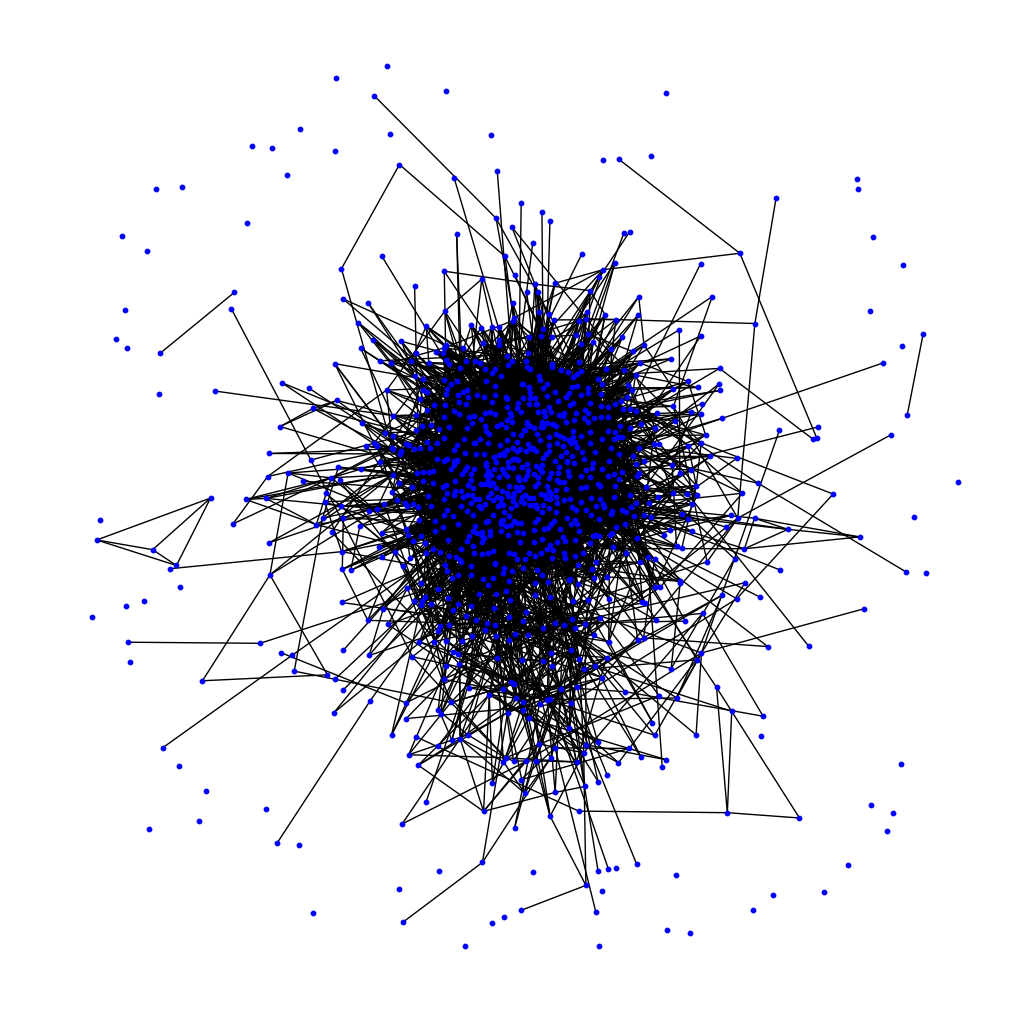

In [172]:
#draw the graph
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G,k=0.09,iterations=24)
nx.draw(G, pos, node_size=10, node_color="blue", with_labels=False)
plt.savefig('Result/graph.png',dpi=300)

In [173]:
#graph analysis
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())
print("Average clustering coefficient: ", nx.average_clustering(G))
print('Average degree:', sum(dict(G.degree()).values())/G.number_of_nodes())
print('Number of connected components:', nx.number_connected_components(G))
print("Density: ", nx.density(G))
with open('Result/graph_info.txt','w') as f:
    f.write("Number of nodes: "+str(G.number_of_nodes())+'\n')
    f.write("Number of edges: "+str(G.number_of_edges())+'\n')
    f.write("Average clustering coefficient: "+str(nx.average_clustering(G))+'\n')
    f.write('Average degree: '+str(sum(dict(G.degree()).values())/G.number_of_nodes())+'\n')
    f.write('Number of connected components: '+str(nx.number_connected_components(G))+'\n')
    f.write("Density: "+str(nx.density(G))+'\n')

Number of nodes:  1028
Number of edges:  7327
Average clustering coefficient:  0.3043159815248051
Average degree: 14.254863813229573
Number of connected components: 69
Density:  0.013880101083962582


In [174]:
largest_cc = G.subgraph(max(nx.connected_components(G), key=len))
print('Size of largest connected component:', largest_cc.number_of_nodes())
print('Number of edges in largest connected component:', largest_cc.number_of_edges())
print('Average clustering coefficient of largest connected component:', nx.average_clustering(largest_cc))
print('Diameter of largest connected component:', nx.diameter(largest_cc))
print('Average shortest path length of largest connected component:', nx.average_shortest_path_length(largest_cc))
with open('Result/graph_info.txt','a') as f:
    f.write('Size of largest connected component: '+str(largest_cc.number_of_nodes())+'\n')
    f.write('Number of edges in largest connected component: '+str(largest_cc.number_of_edges())+'\n')
    f.write('Average clustering coefficient of largest connected component: '+str(nx.average_clustering(largest_cc))+'\n')
    f.write('Diameter of largest connected component: '+str(nx.diameter(largest_cc))+'\n')
    f.write('Average shortest path length of largest connected component: '+str(nx.average_shortest_path_length(largest_cc))+'\n')

Size of largest connected component: 955
Number of edges in largest connected component: 7319
Average clustering coefficient of largest connected component: 0.3233893497460729
Diameter of largest connected component: 10
Average shortest path length of largest connected component: 3.269421669026529


In [175]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count={}
for d in degree_sequence:
    if d not in degree_count:
        degree_count[d]=0
    degree_count[d]+=1
degree_count

{98: 1,
 94: 1,
 93: 1,
 91: 1,
 90: 1,
 88: 1,
 87: 1,
 83: 1,
 81: 1,
 78: 1,
 77: 1,
 76: 1,
 75: 1,
 73: 1,
 70: 2,
 69: 2,
 68: 3,
 67: 1,
 66: 1,
 65: 2,
 64: 1,
 63: 1,
 62: 1,
 61: 5,
 60: 2,
 59: 1,
 58: 3,
 57: 1,
 56: 4,
 54: 2,
 52: 2,
 51: 2,
 50: 3,
 49: 1,
 48: 2,
 47: 1,
 46: 3,
 45: 7,
 44: 3,
 43: 6,
 42: 2,
 41: 5,
 40: 2,
 39: 5,
 38: 3,
 37: 5,
 36: 1,
 35: 4,
 34: 5,
 33: 6,
 32: 7,
 31: 7,
 30: 14,
 29: 2,
 28: 7,
 27: 12,
 26: 6,
 25: 9,
 24: 11,
 23: 15,
 22: 14,
 21: 9,
 20: 19,
 19: 18,
 18: 18,
 17: 14,
 16: 21,
 15: 19,
 14: 19,
 13: 29,
 12: 26,
 11: 38,
 10: 34,
 9: 32,
 8: 38,
 7: 41,
 6: 54,
 5: 60,
 4: 55,
 3: 82,
 2: 59,
 1: 60,
 0: 65}

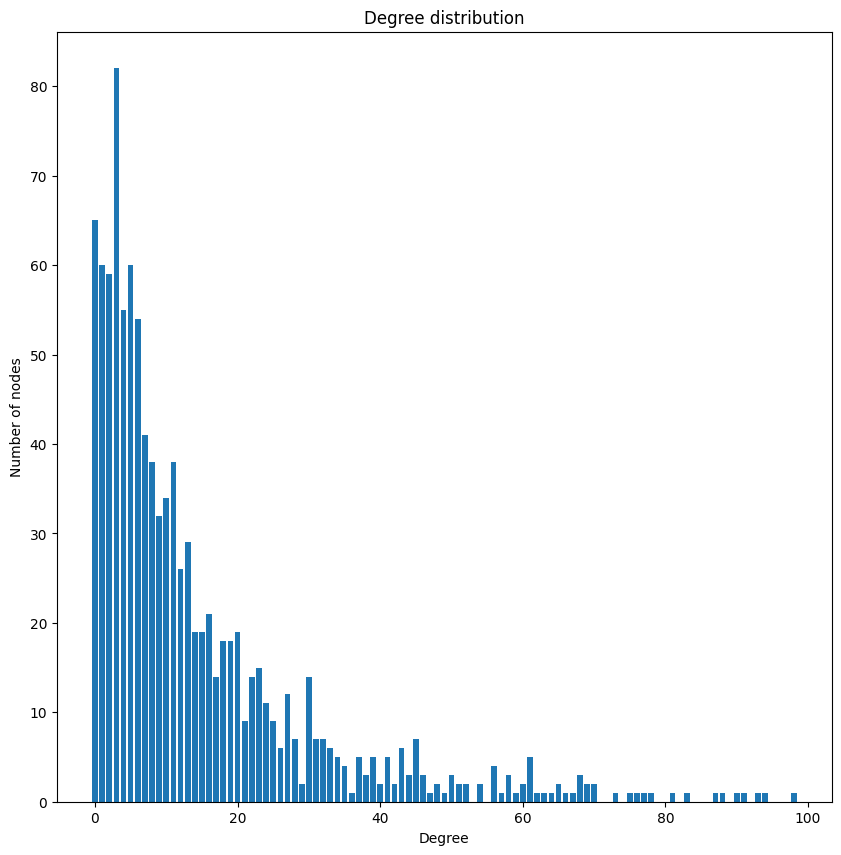

In [176]:
plt.figure(figsize=(10,10))
plt.bar(degree_count.keys(),degree_count.values())
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Degree distribution')
plt.savefig('Result/degree_distribution.png')

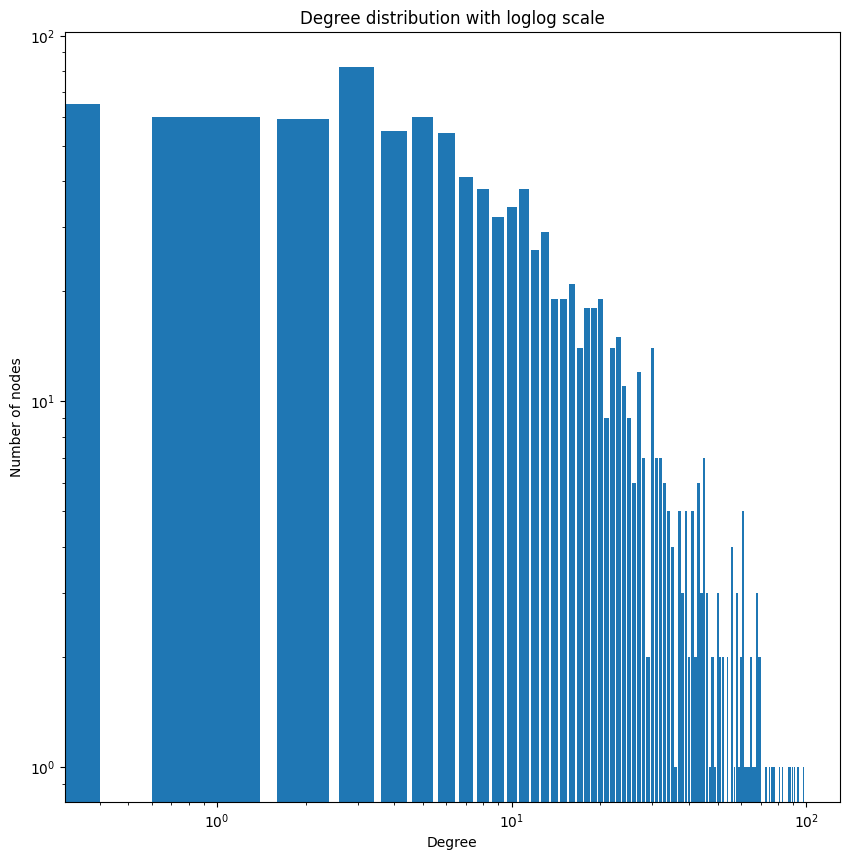

In [177]:
#with loglog scale
plt.figure(figsize=(10,10))
plt.bar(degree_count.keys(),degree_count.values())
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.yscale('log')
plt.xscale('log')
plt.title('Degree distribution with loglog scale')
plt.savefig('Result/degree_distribution_loglog.png')

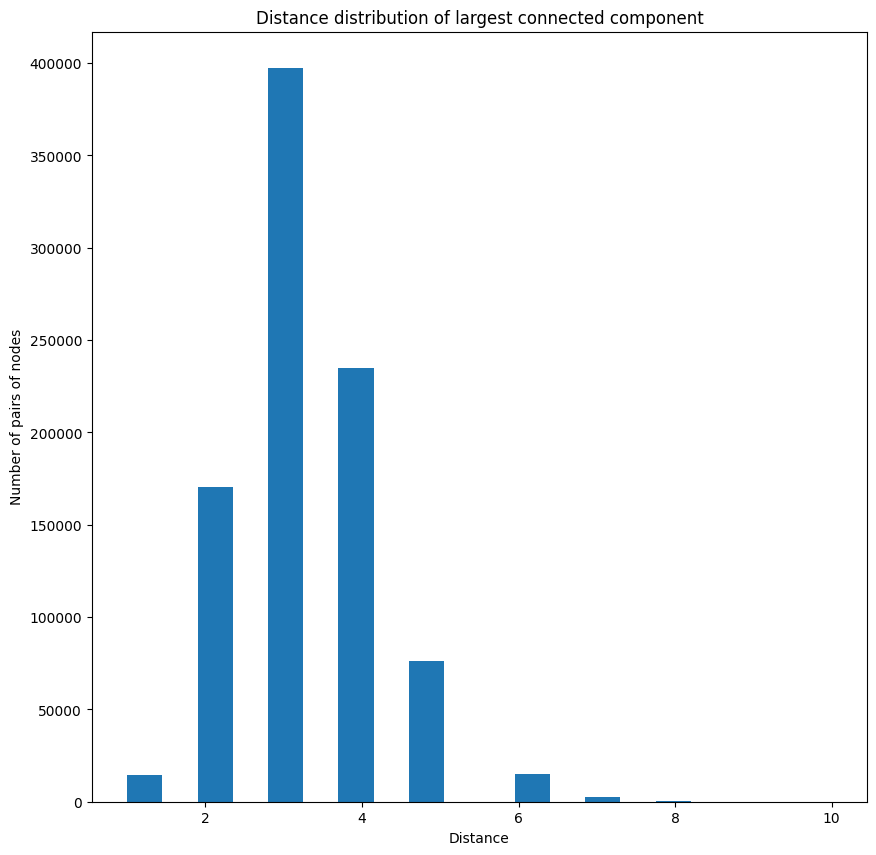

In [178]:
#distance distribution of largest connected component
distances = dict(nx.all_pairs_shortest_path_length(largest_cc))
all_len=[]
for source,len1 in distances.items():
    all_len.extend(list(len1.values()))
all_len=[x for x in all_len if x!=0]
plt.figure(figsize=(10,10))
plt.hist(all_len,bins=20)
plt.xlabel('Distance')
plt.ylabel('Number of pairs of nodes')
plt.title('Distance distribution of largest connected component')
plt.savefig('Result/distance_distribution.png')

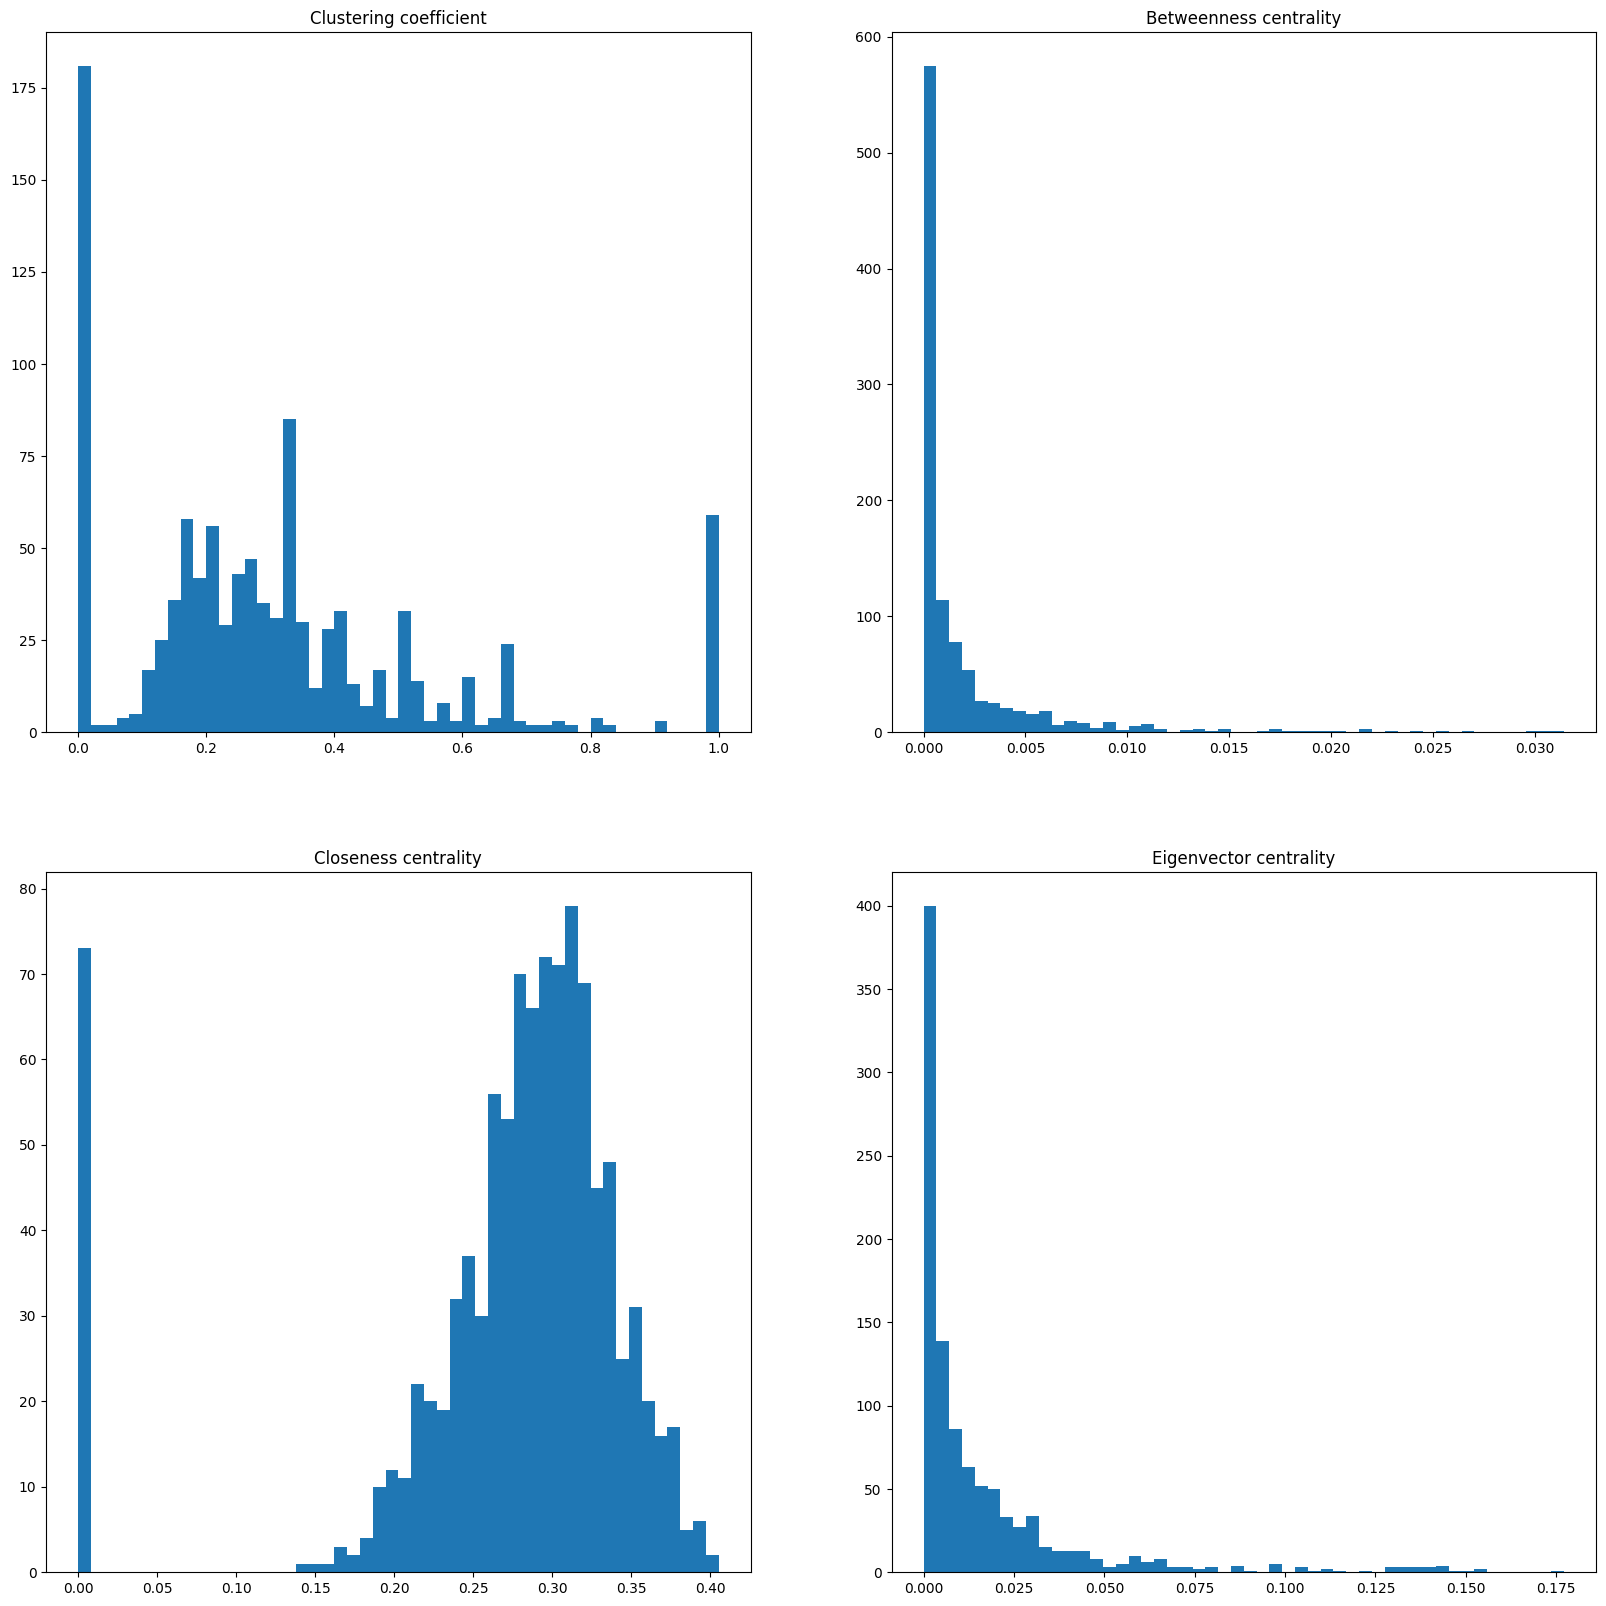

In [179]:
#centrality distribution
clustering_coefficient = nx.clustering(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0, 0].hist(clustering_coefficient.values(), bins=50)
ax[0, 0].set_title('Clustering coefficient')
ax[0, 1].hist(betweenness_centrality.values(), bins=50)
ax[0, 1].set_title('Betweenness centrality')
ax[1, 0].hist(closeness_centrality.values(), bins=50)
ax[1, 0].set_title('Closeness centrality')
ax[1, 1].hist(eigenvector_centrality.values(), bins=50)
ax[1, 1].set_title('Eigenvector centrality')
plt.savefig('Result/centrality_distribution.png')

In [188]:
#yearly graph analysis
with open('Input/year_edges.pkl','rb') as f:
    year_edges=pickle.load(f)
with open('Input/pid_idx.pkl','rb') as f:
    pid_idx=pickle.load(f)
with open('Input/inv_pid_idx.pkl','rb') as f:
    inv_pid_idx=pickle.load(f)
with open('Input/year_nodes.pkl','rb') as f:
    year_nodes=pickle.load(f)    

## Question 2: Properties change of yearly collaboration network

In [156]:
Gs={}
for year in year_edges:
    G1=nx.Graph()
    for n in year_edges[year]:
        G1.add_node(n)
    G1.add_edges_from(year_edges[year])
    Gs[year]=G1
#sort the dictionary by year
Gs=dict(sorted(Gs.items()))

In [166]:
year_info={}
for y in Gs:
    Gy=Gs[y]
    year_info[y]={}
    year_info[y]['Number of nodes']=Gy.number_of_nodes()
    year_info[y]['Number of edges']=Gy.number_of_edges()
    year_info[y]['Average clustering coefficient']=nx.average_clustering(Gy)
    year_info[y]['Average degree']=sum(dict(Gy.degree()).values())/Gy.number_of_nodes()
    year_info[y]['Number of connected components']=nx.number_connected_components(Gy)
    year_info[y]['Density']=nx.density(Gy)
    largest_cc = Gy.subgraph(max(nx.connected_components(Gy), key=len))
    year_info[y]['Size of largest connected component']=largest_cc.number_of_nodes()
    year_info[y]['Number of edges in largest connected component']=largest_cc.number_of_edges()
    year_info[y]['Average clustering coefficient of largest connected component']=nx.average_clustering(largest_cc)
    year_info[y]['Diameter of largest connected component']=nx.diameter(largest_cc)
    year_info[y]['Average shortest path length of largest connected component']=nx.average_shortest_path_length(largest_cc)
    year_info[y]["highest degree centrality"]=max(nx.degree_centrality(Gy).values())
    year_info[y]["highest betweenness centrality"]=max(nx.betweenness_centrality(Gy).values())
    year_info[y]["highest closeness centrality"]=max(nx.closeness_centrality(Gy).values())
    year_info[y]["highest clustering coefficient"]=max(nx.clustering(Gy).values())
    year_info[y]["highest degree"]=max(dict(Gy.degree()).values())
    #draw the graph
    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(Gy,k=0.09,iterations=24)
    nx.draw(Gy, pos, node_size=10, node_color="blue", with_labels=False)
    plt.title(y)
    plt.savefig('Result/yeargraph/'+y+'.png',dpi=300)
    plt.close()

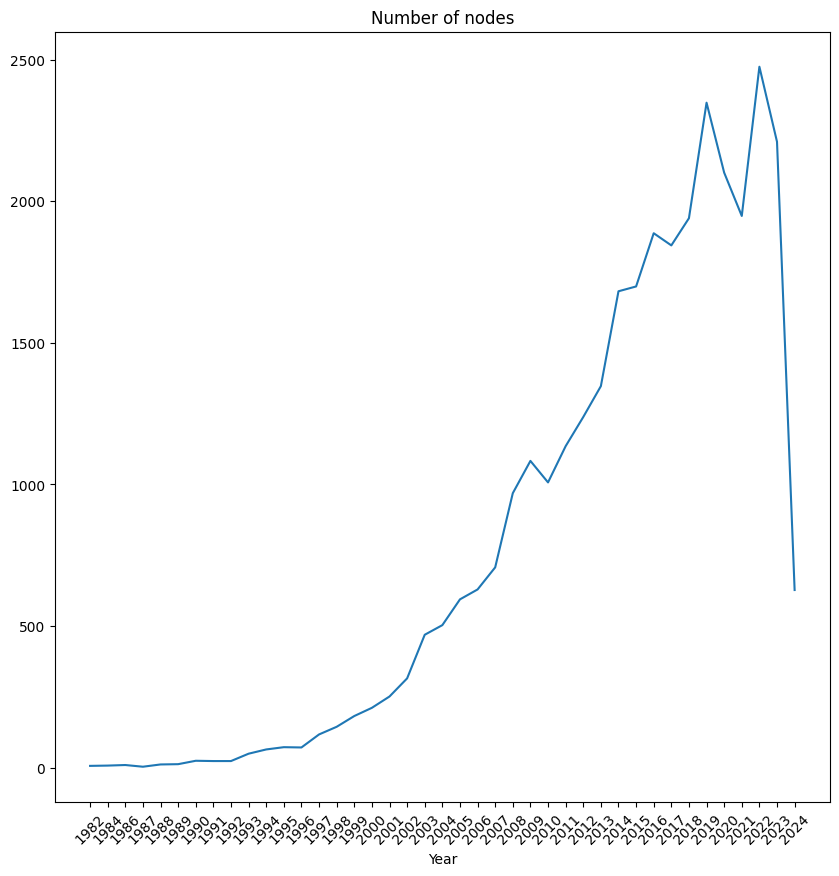

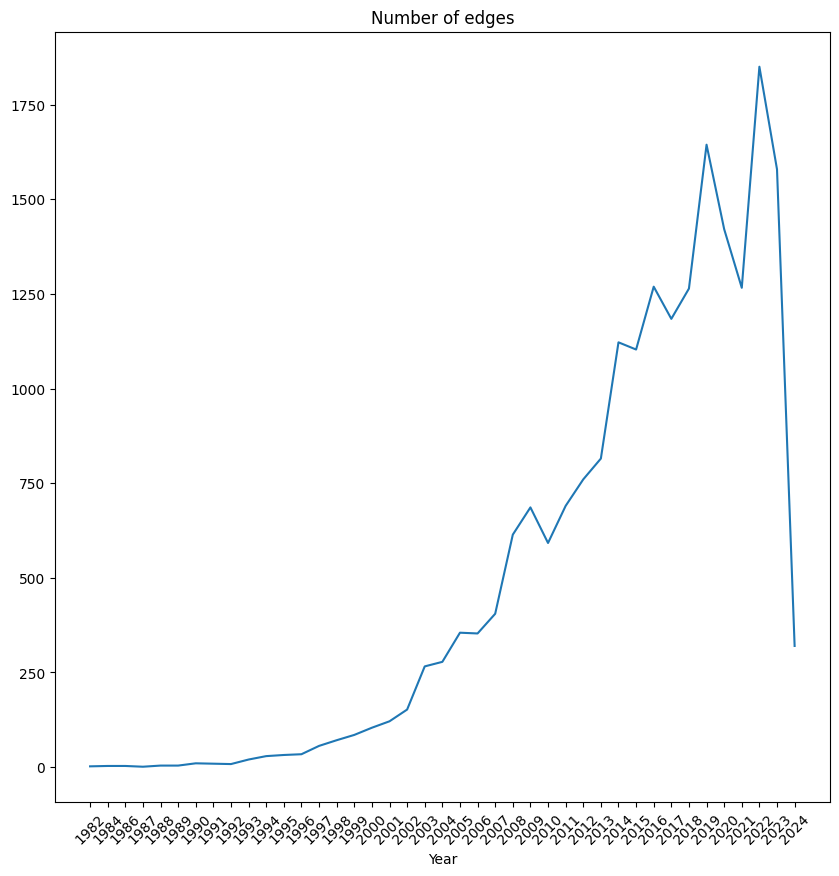

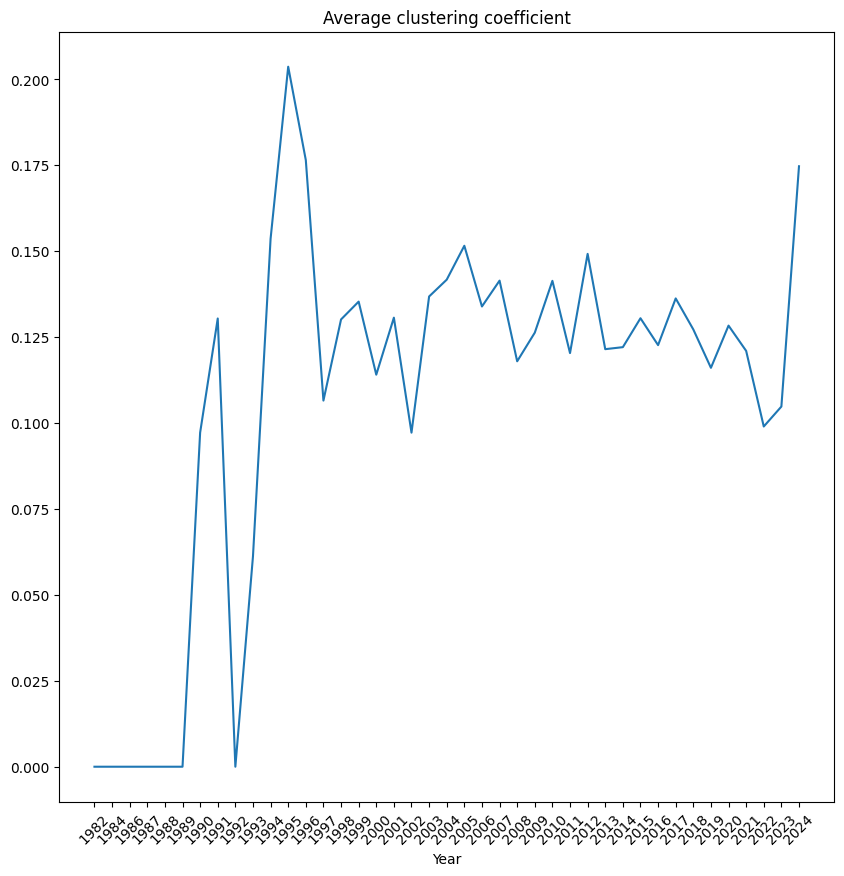

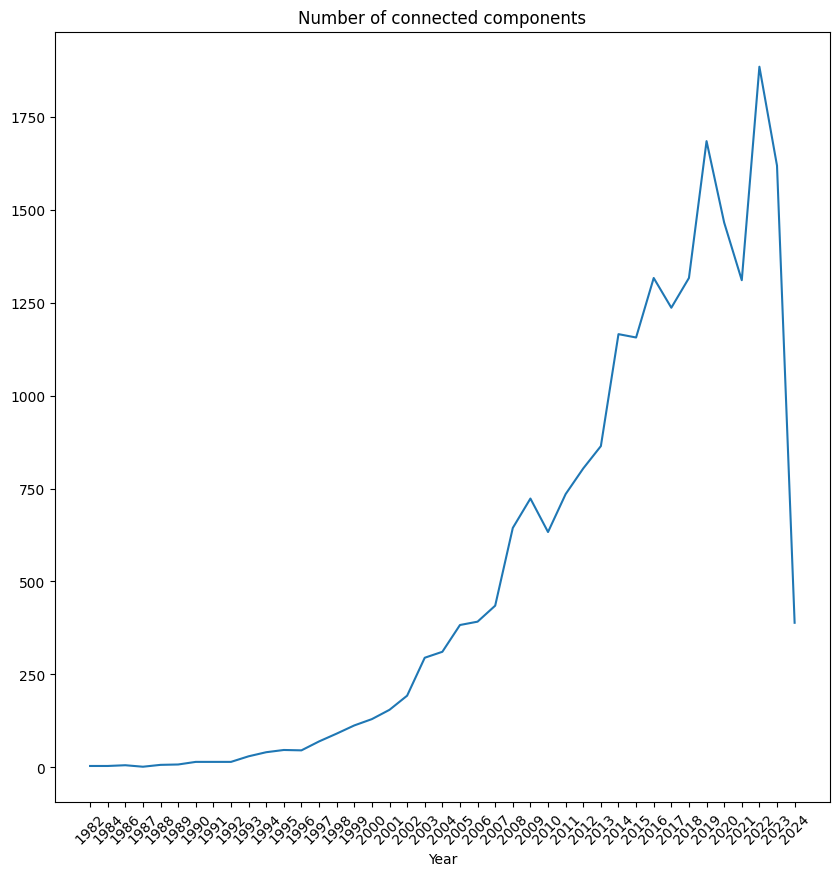

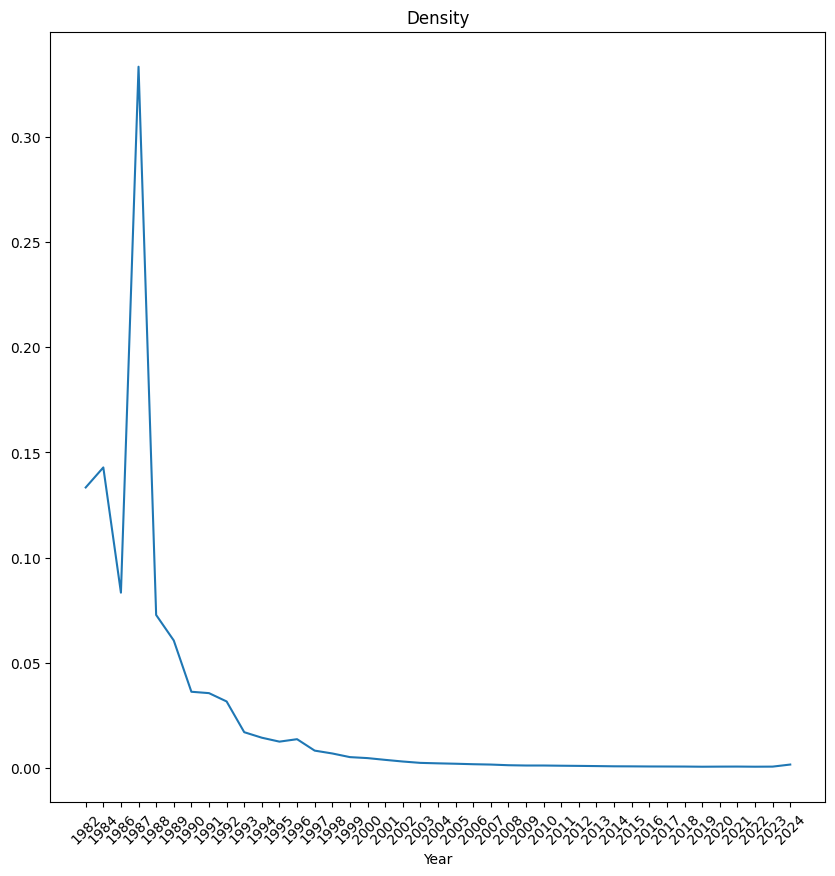

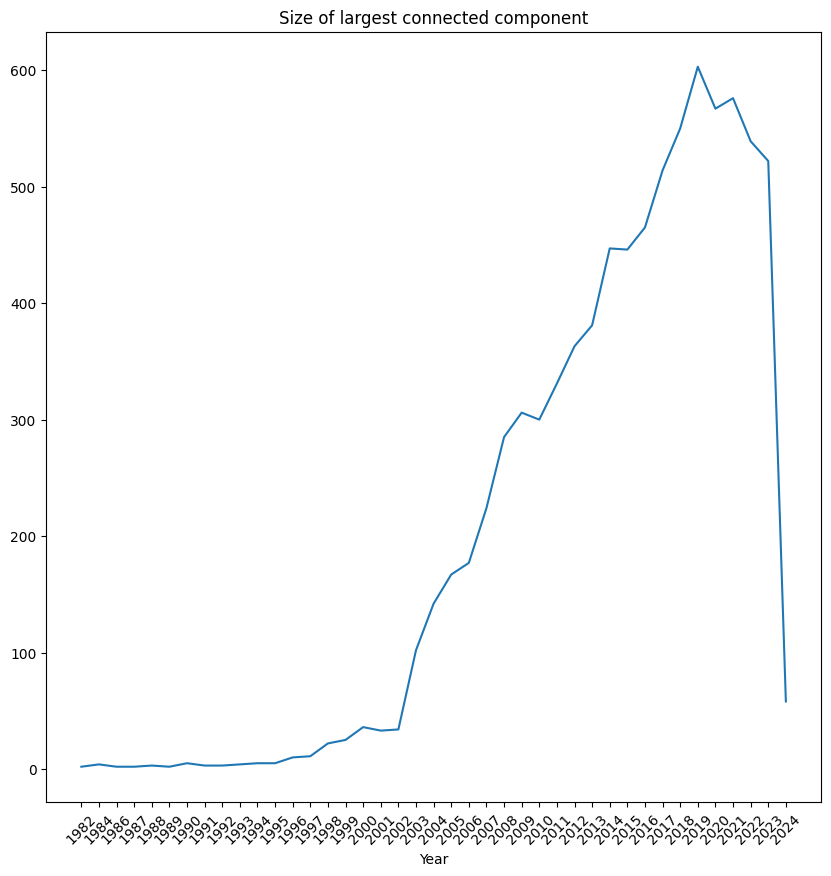

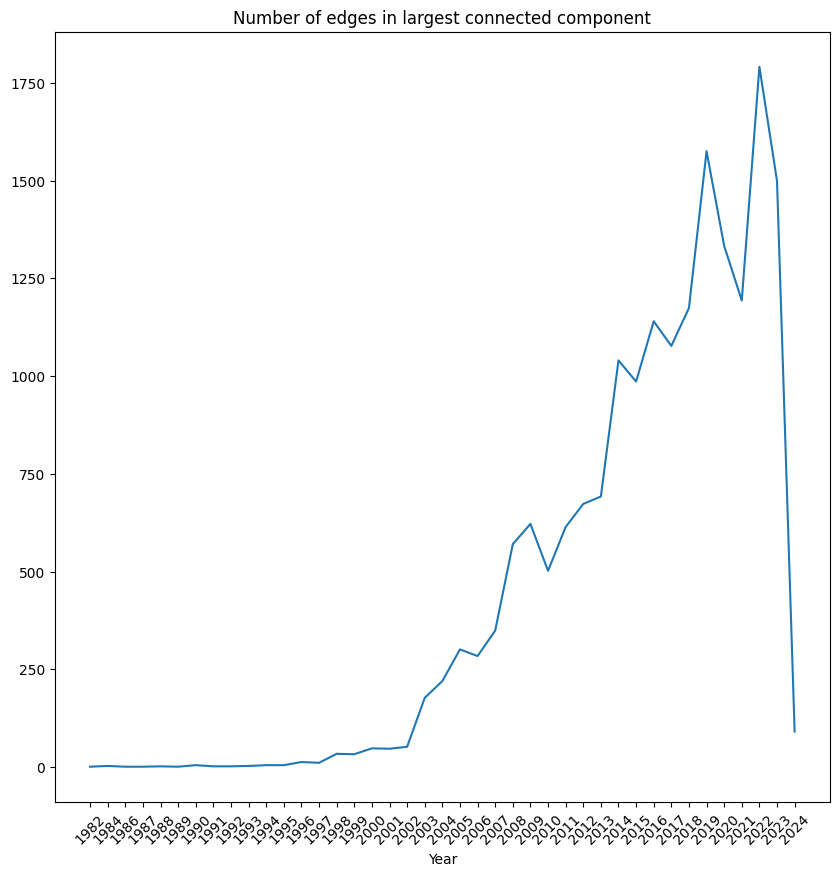

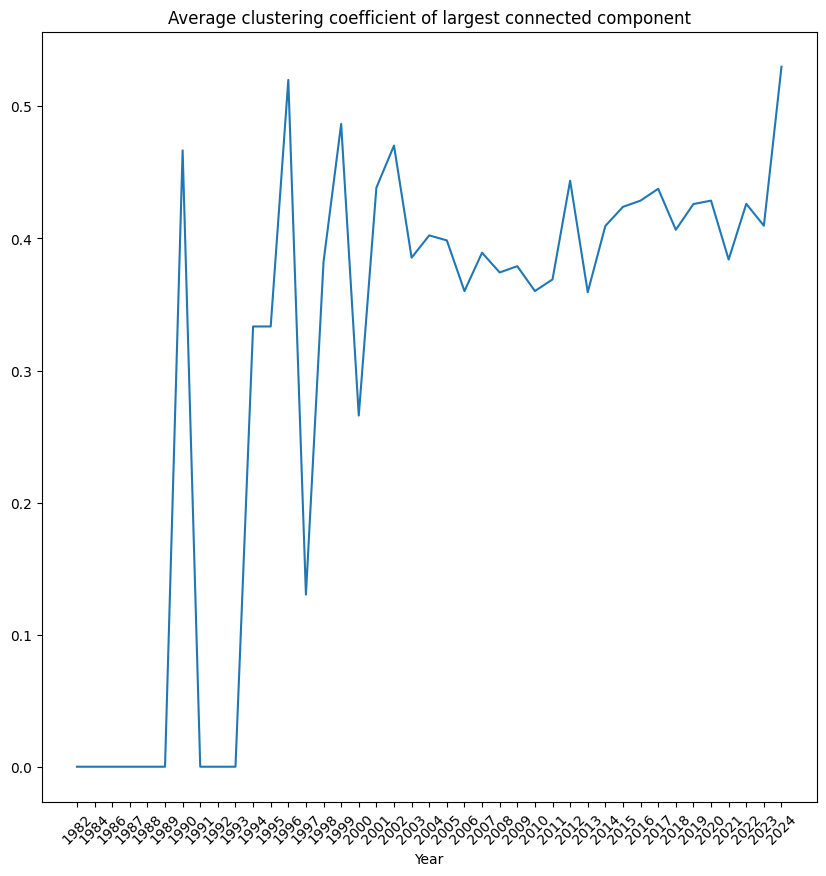

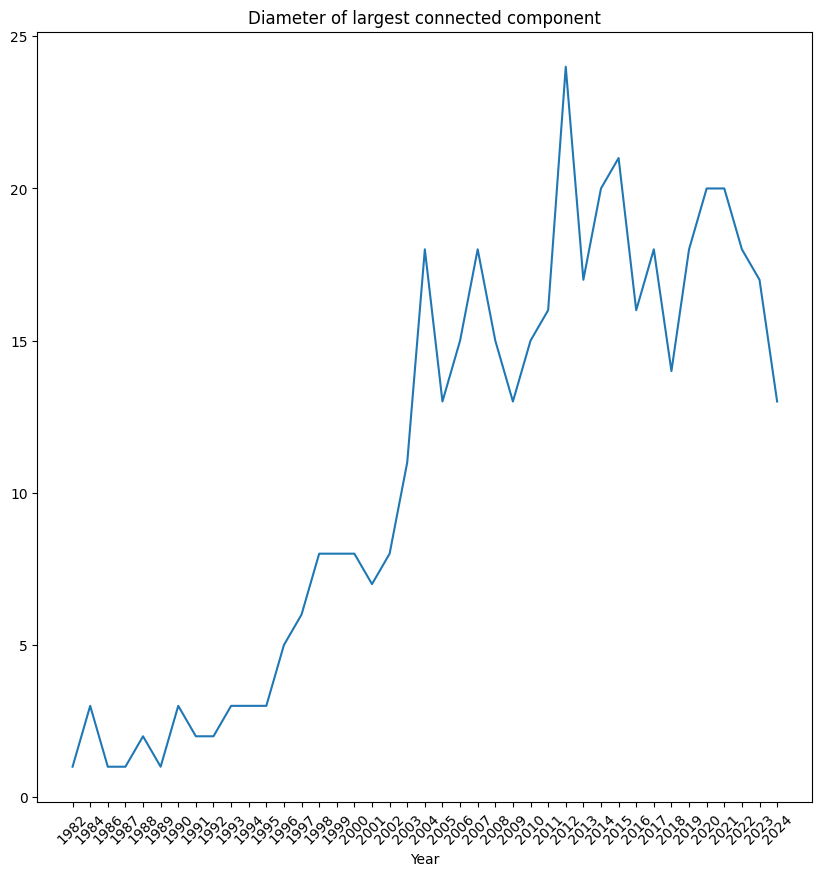

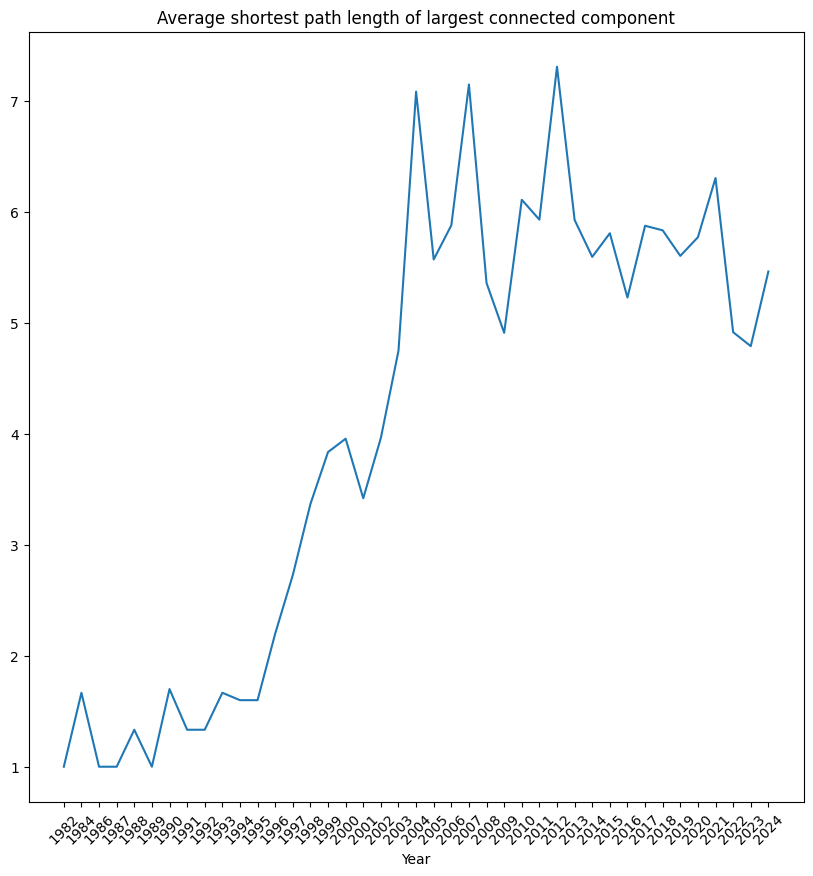

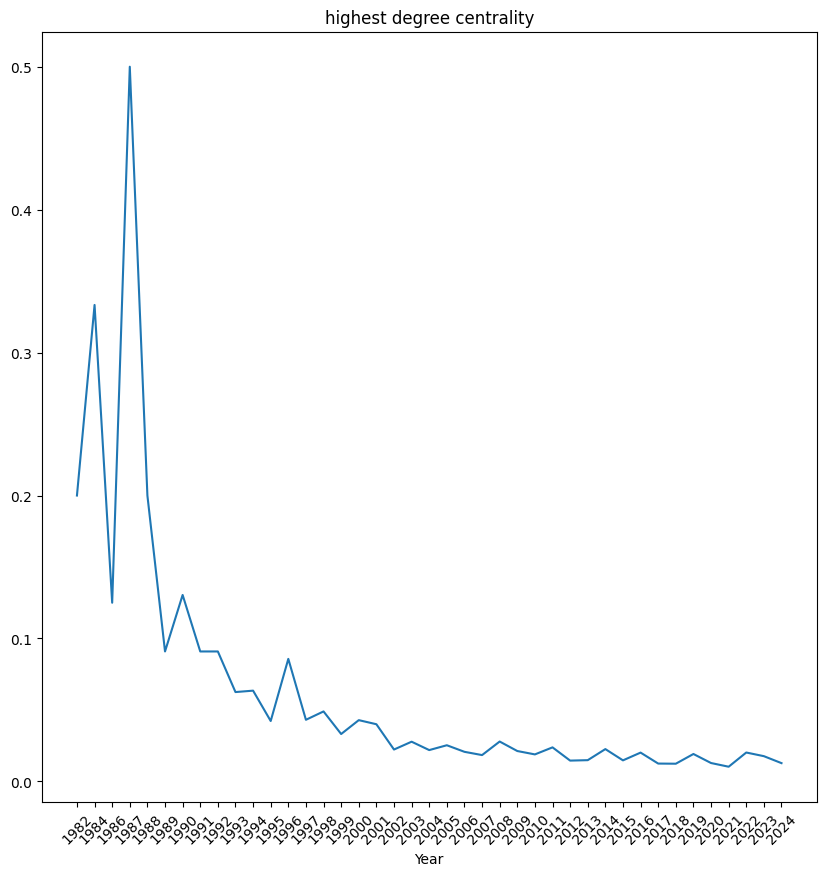

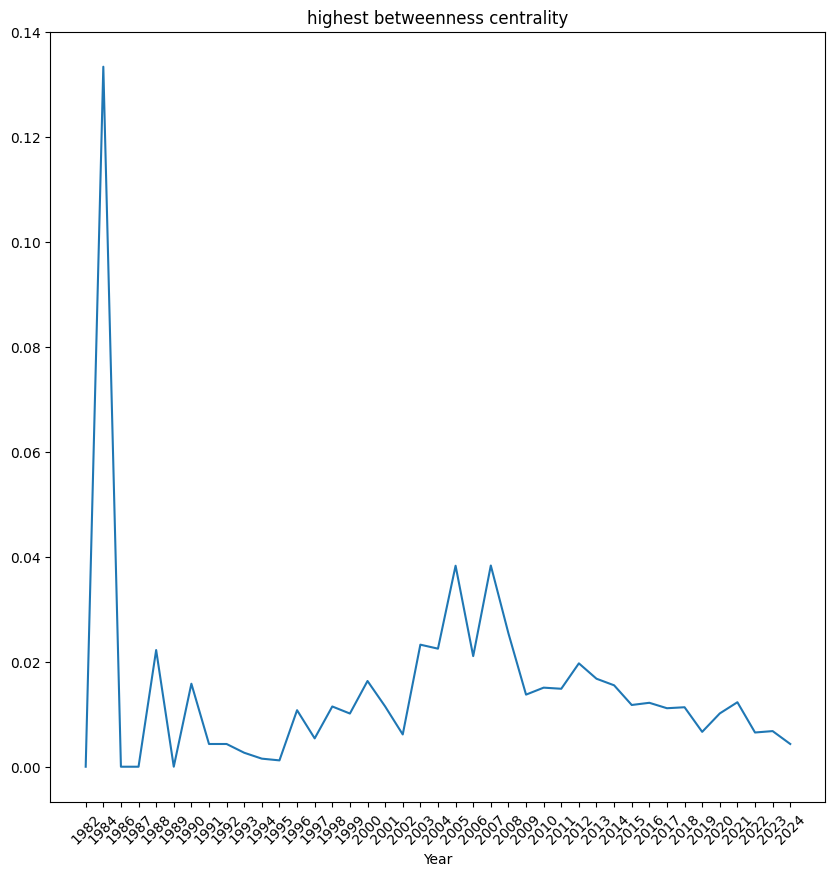

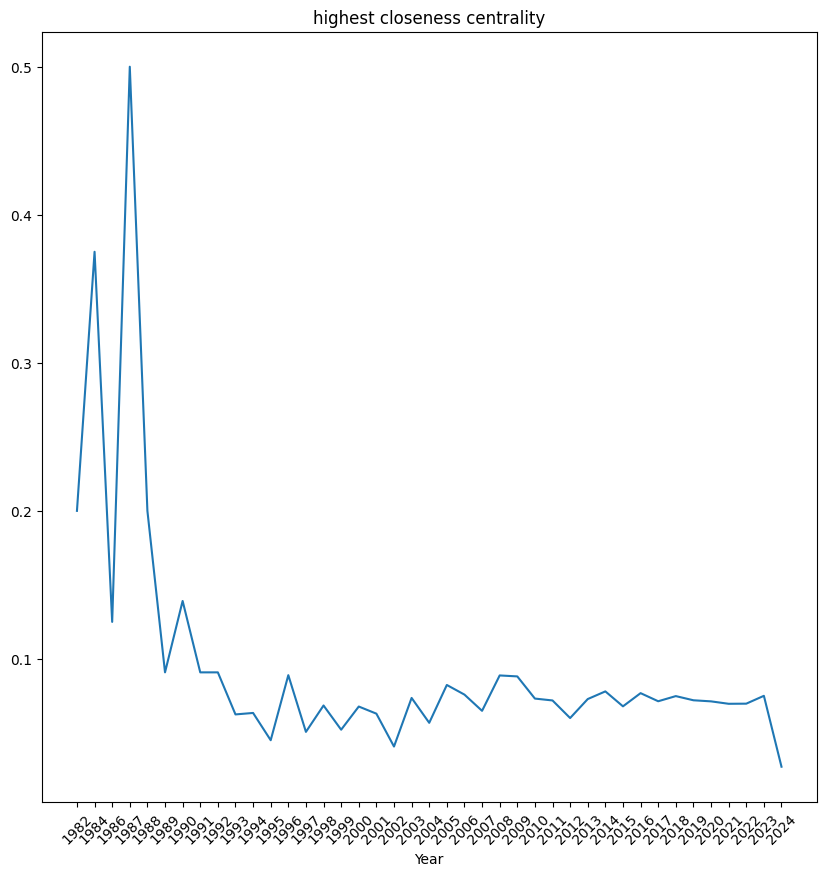

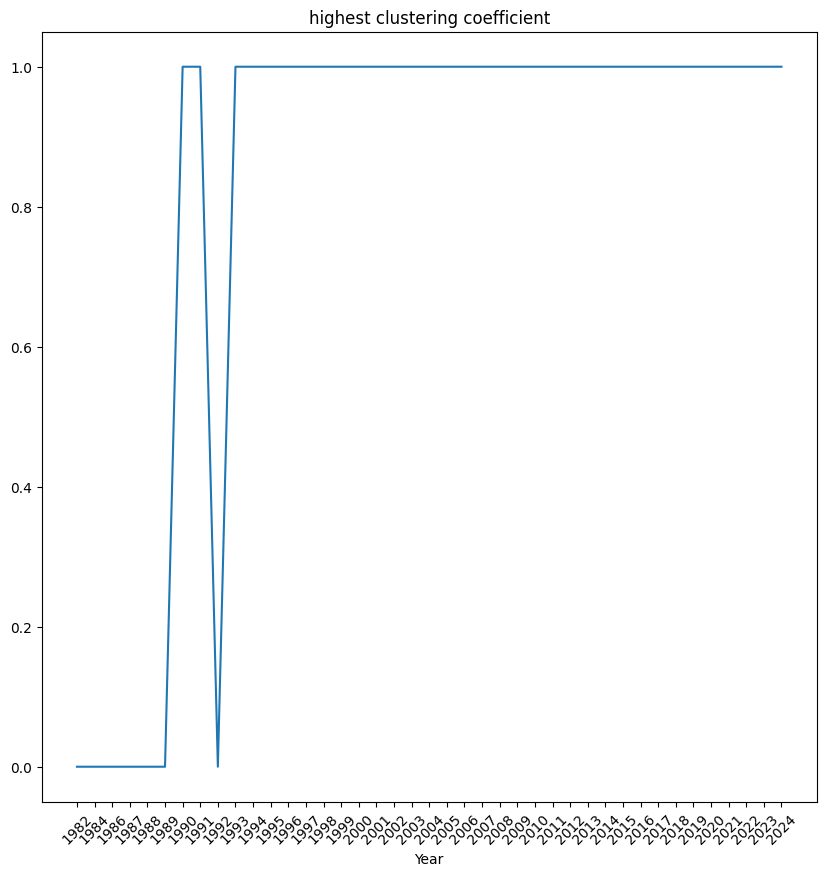

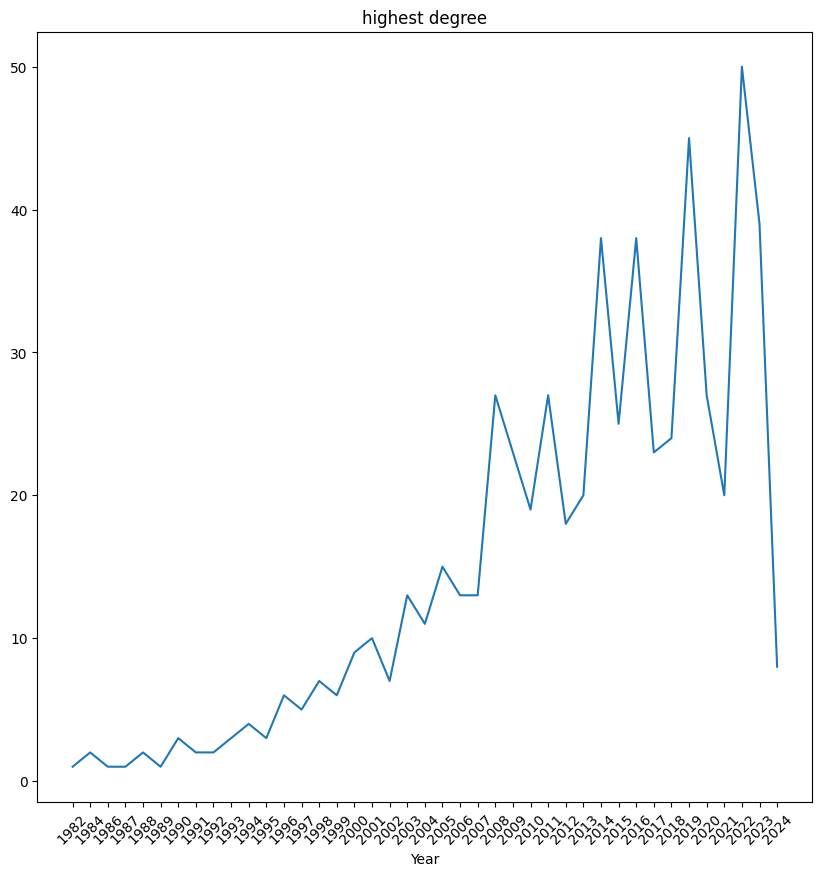

In [169]:
#draw the line chart for each property
for key in year_info['2000'].keys():   
    if key=="Average degree":
        continue
    plt.figure(figsize=(10,10))
    plt.plot(list(year_info.keys()),[year_info[y][key] for y in year_info.keys()])
    plt.xlabel('Year')
    plt.title(key)
    plt.xticks(rotation=45)
    plt.savefig('Result/PropertyChange/'+key+'.png')

In [170]:
#print the year info for each property,save to a txt file
with open('Result/PropertyChange.txt','w') as f:
    for key in year_info['2000'].keys():
        f.write(key+'\n')
        for y in year_info:
            f.write(y+':'+str(year_info[y][key])+'\n')
            print(y,year_info[y][key])
        f.write('\n')

1982 6
1984 7
1986 9
1987 3
1988 11
1989 12
1990 24
1991 23
1992 23
1993 49
1994 64
1995 72
1996 71
1997 117
1998 144
1999 182
2000 211
2001 251
2002 315
2003 469
2004 503
2005 594
2006 629
2007 707
2008 969
2009 1083
2010 1007
2011 1135
2012 1238
2013 1347
2014 1682
2015 1699
2016 1887
2017 1844
2018 1940
2019 2348
2020 2101
2021 1948
2022 2475
2023 2210
2024 627
1982 2
1984 3
1986 3
1987 1
1988 4
1989 4
1990 10
1991 9
1992 8
1993 20
1994 29
1995 32
1996 34
1997 56
1998 71
1999 85
2000 104
2001 121
2002 152
2003 266
2004 278
2005 355
2006 353
2007 405
2008 614
2009 686
2010 592
2011 690
2012 760
2013 815
2014 1122
2015 1103
2016 1269
2017 1184
2018 1264
2019 1644
2020 1421
2021 1266
2022 1850
2023 1579
2024 320
1982 0.0
1984 0.0
1986 0.0
1987 0.0
1988 0.0
1989 0.0
1990 0.09722222222222221
1991 0.13043478260869565
1992 0.0
1993 0.061224489795918366
1994 0.15364583333333331
1995 0.20370370370370372
1996 0.17652582159624414
1997 0.10655270655270656
1998 0.13015873015873017
1999 0.1353479

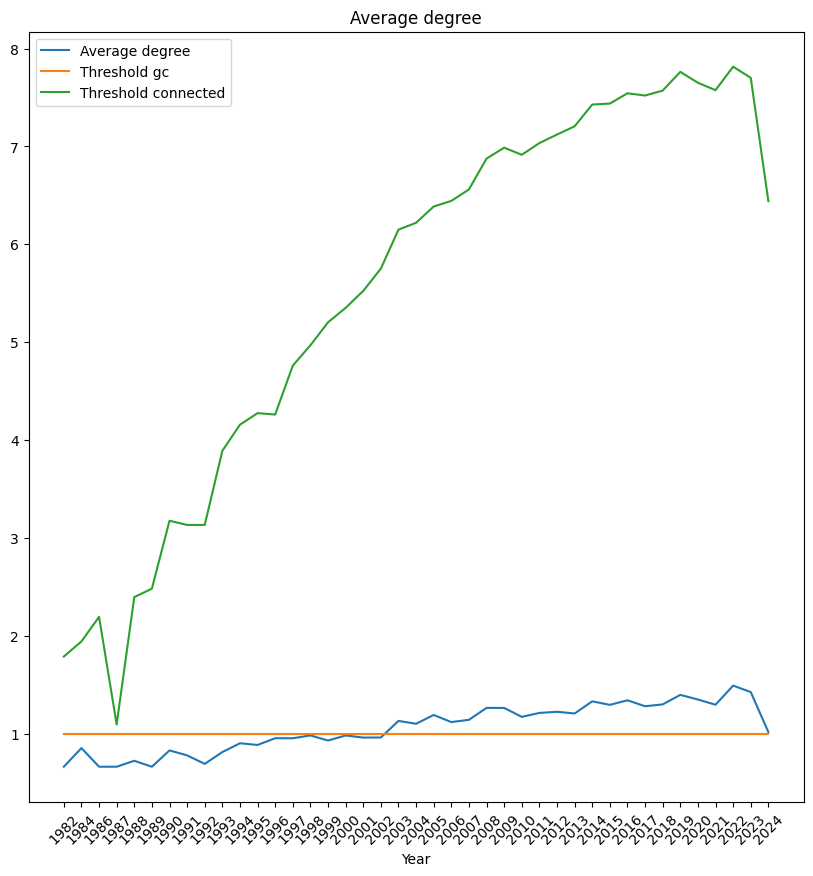

In [187]:
#draw the average degree line chart with 2 threshold 1 and ln(n)
plt.figure(figsize=(10,10))
plt.plot(list(year_info.keys()),[year_info[y]['Average degree'] for y in year_info.keys()])
plt.plot(list(year_info.keys()),[1 for y in year_info.keys()])
plt.plot(list(year_info.keys()),[np.log(year_info[y]['Number of nodes']) for y in year_info.keys()])
plt.xlabel('Year')
plt.title('Average degree')
plt.xticks(rotation=45)
plt.legend(['Average degree','Threshold gc','Threshold connected'])
plt.savefig('Result/PropertyChange/Average degree.png')

## Question 3: Random graph comparison
We will compare the properties of the collaboration network with random graph with same number of node and edges.
It contains following properties:
1. average clustering coefficient
2. number of connected components
3. size of largest connected component
4. number of edges in largest connected component
5. average shortest path length of largest connected component
6. diameter of largest connected component
7. degree distribution
8. distance distribution in largest connected component
9. centrality distribution for clustering coefficient, betweenness centrality, closeness centrality, eigenvector centrality

In [259]:
m=len(G.edges())
n=len(G.nodes())
p=m/(n*(n-1)/2)
m_gc=len(G.subgraph(max(nx.connected_components(G), key=len)).edges())
n_gc=len(G.subgraph(max(nx.connected_components(G), key=len)).nodes())
def equation(m1,n,E):
    return m1*(n-m1)+m1*(m1-1)/2-E
m1=int(fsolve(equation,m/n,args=(n_gc,m_gc))[0])
k=(int(2*m/n)//2)*2

In [260]:
G_ER_np=nx.erdos_renyi_graph(n,p)
G_ER_nm=nx.gnm_random_graph(n,m)
G_BA=nx.barabasi_albert_graph(n_gc,m1)
G_WS=nx.watts_strogatz_graph(n,k,0.24)#0.24 is a value tried by experiment

In [261]:
#graph analysis
G_ER_np_info={}
G_ER_nm_info={}
G_info={}
G_BA_info={}
G_WS_info={}

In [262]:
#average clustering coefficient
G_ER_np_info['Average clustering coefficient']=nx.average_clustering(G_ER_np)
G_ER_nm_info['Average clustering coefficient']=nx.average_clustering(G_ER_nm)
G_info['Average clustering coefficient']=nx.average_clustering(G)
G_BA_info['Average clustering coefficient']=nx.average_clustering(G_BA)
G_WS_info['Average clustering coefficient']=nx.average_clustering(G_WS)

In [263]:
#number of connected components
G_ER_np_info['Number of connected components']=nx.number_connected_components(G_ER_np)
G_ER_nm_info['Number of connected components']=nx.number_connected_components(G_ER_nm)
G_info['Number of connected components']=nx.number_connected_components(G)
G_BA_info['Number of connected components']=nx.number_connected_components(G_BA)
G_WS_info['Number of connected components']=nx.number_connected_components(G_WS)

In [264]:
#size of largest connected component
largest_cc_ER_np = G_ER_np.subgraph(max(nx.connected_components(G_ER_np), key=len))
largest_cc_ER_nm = G_ER_nm.subgraph(max(nx.connected_components(G_ER_nm), key=len))
largest_cc_G = G.subgraph(max(nx.connected_components(G), key=len))
largest_cc_BA = G_BA.subgraph(max(nx.connected_components(G_BA), key=len))
largest_cc_WS = G_WS.subgraph(max(nx.connected_components(G_WS), key=len))
G_ER_np_info['Size of largest connected component']=largest_cc_ER_np.number_of_nodes()
G_ER_nm_info['Size of largest connected component']=largest_cc_ER_nm.number_of_nodes()
G_info['Size of largest connected component']=largest_cc_G.number_of_nodes()
G_BA_info['Size of largest connected component']=largest_cc_BA.number_of_nodes()
G_WS_info['Size of largest connected component']=largest_cc_WS.number_of_nodes()

In [265]:
#number of edges in largest connected component
G_ER_np_info['Number of edges in largest connected component']=largest_cc_ER_np.number_of_edges()
G_ER_nm_info['Number of edges in largest connected component']=largest_cc_ER_nm.number_of_edges()
G_info['Number of edges in largest connected component']=largest_cc_G.number_of_edges()
G_BA_info['Number of edges in largest connected component']=largest_cc_BA.number_of_edges()
G_WS_info['Number of edges in largest connected component']=largest_cc_WS.number_of_edges()

In [266]:
#average shortest path length of largest connected component
G_ER_np_info['Average shortest path length of largest connected component']=nx.average_shortest_path_length(largest_cc_ER_np)
G_ER_nm_info['Average shortest path length of largest connected component']=nx.average_shortest_path_length(largest_cc_ER_nm)
G_info['Average shortest path length of largest connected component']=nx.average_shortest_path_length(largest_cc_G)
G_BA_info['Average shortest path length of largest connected component']=nx.average_shortest_path_length(largest_cc_BA)
G_WS_info['Average shortest path length of largest connected component']=nx.average_shortest_path_length(largest_cc_WS)

In [267]:
#diameter of largest connected component
G_ER_np_info['Diameter of largest connected component']=nx.diameter(largest_cc_ER_np)
G_ER_nm_info['Diameter of largest connected component']=nx.diameter(largest_cc_ER_nm)
G_info['Diameter of largest connected component']=nx.diameter(largest_cc_G)
G_BA_info['Diameter of largest connected component']=nx.diameter(largest_cc_BA)
G_WS_info['Diameter of largest connected component']=nx.diameter(largest_cc_WS)

In [287]:
#merge to a dataframe
df=pd.DataFrame([G_ER_np_info,G_ER_nm_info,G_info,G_BA_info,G_WS_info],index=['ER_np','ER_nm','G','BA','WS'])
df.to_csv('Result/RandomGraph/RandomGraphInfo.csv')

In [269]:
#degree distribution
def degree_distribution(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degree_count={}
    for d in degree_sequence:
        if d not in degree_count:
            degree_count[d]=0
        degree_count[d]+=1
    return degree_count

In [270]:
degree_count_ER_np=degree_distribution(G_ER_np)
degree_count_ER_nm=degree_distribution(G_ER_nm)
degree_count_G=degree_distribution(G)
degree_count_BA=degree_distribution(G_BA)
degree_count_WS=degree_distribution(G_WS)

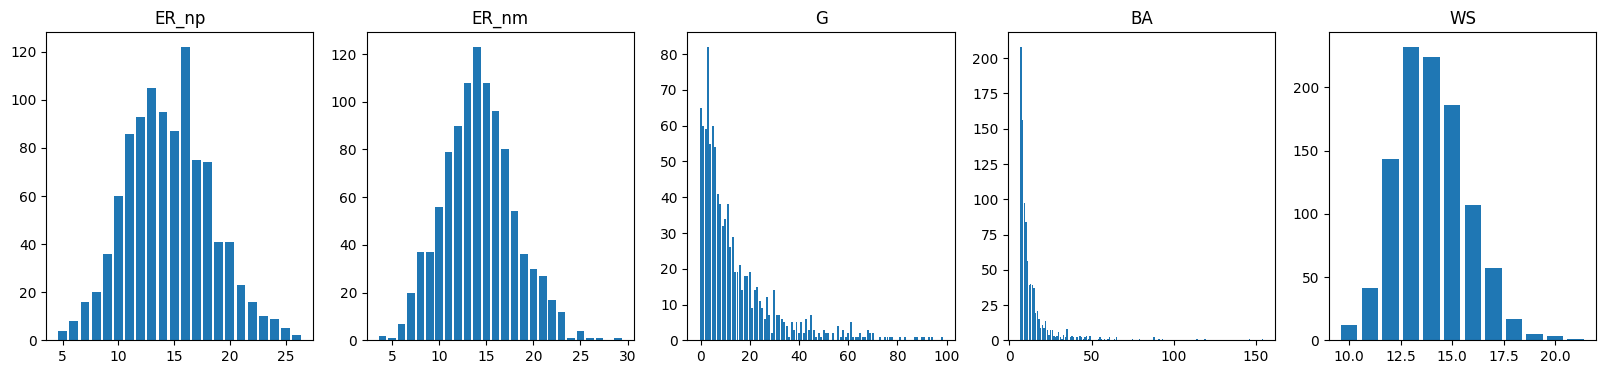

In [290]:
#draw the degree distribution
fig, ax = plt.subplots(1,5, figsize=(20, 4))
ax[0].bar(degree_count_ER_np.keys(),degree_count_ER_np.values())
ax[0].set_title('ER_np')
ax[1].bar(degree_count_ER_nm.keys(),degree_count_ER_nm.values())
ax[1].set_title('ER_nm')
ax[2].bar(degree_count_G.keys(),degree_count_G.values())
ax[2].set_title('G')
ax[3].bar(degree_count_BA.keys(),degree_count_BA.values())
ax[3].set_title('BA')
ax[4].bar(degree_count_WS.keys(),degree_count_WS.values())
ax[4].set_title('WS')
plt.savefig('Result/RandomGraph/degree_distribution_random.png',dpi=300)

In [275]:
#distance distribution
def distance_distribution(G):
    distances = dict(nx.all_pairs_shortest_path_length(G))
    all_len=[]
    for source,len1 in distances.items():
        all_len.extend(list(len1.values()))
    all_len=[x for x in all_len if x!=0]
    return all_len

In [276]:
distance_ER_np=distance_distribution(largest_cc_ER_np)
distance_ER_nm=distance_distribution(largest_cc_ER_nm)
distance_G=distance_distribution(largest_cc_G)
distance_BA=distance_distribution(largest_cc_BA)
distance_WS=distance_distribution(largest_cc_WS)


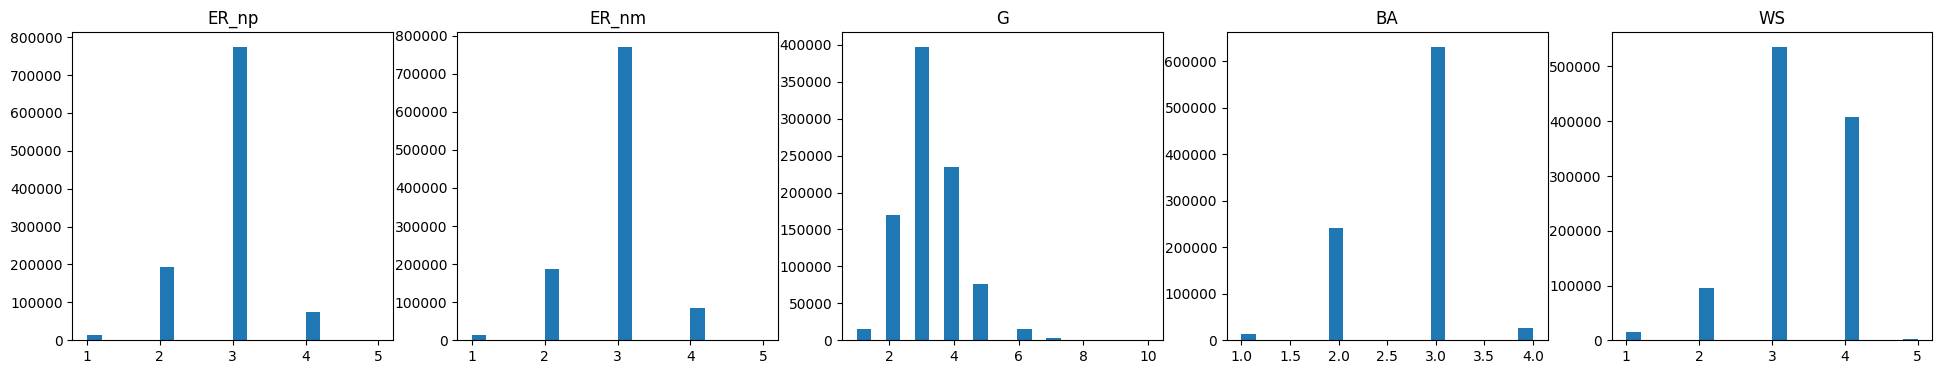

In [289]:
#draw the distance distribution
fig, ax = plt.subplots(1,5, figsize=(24, 4))
ax[0].hist(distance_ER_np,bins=20)
ax[0].set_title('ER_np')
ax[1].hist(distance_ER_nm,bins=20)
ax[1].set_title('ER_nm')
ax[2].hist(distance_G,bins=20)
ax[2].set_title('G')
ax[3].hist(distance_BA,bins=20)
ax[3].set_title('BA')
ax[4].hist(distance_WS,bins=20)
ax[4].set_title('WS')
plt.savefig('Result/RandomGraph/distance_distribution_random.png',dpi=300)

In [279]:
#centrality distribution
def centrality_distribution(G):
    clustering_coefficient = nx.clustering(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)
    return clustering_coefficient,betweenness_centrality,closeness_centrality,eigenvector_centrality

In [280]:
clustering_coefficient_ER_np,betweenness_centrality_ER_np,closeness_centrality_ER_np,eigenvector_centrality_ER_np=centrality_distribution(G_ER_np)
clustering_coefficient_ER_nm,betweenness_centrality_ER_nm,closeness_centrality_ER_nm,eigenvector_centrality_ER_nm=centrality_distribution(G_ER_nm)
clustering_coefficient_G,betweenness_centrality_G,closeness_centrality_G,eigenvector_centrality_G=centrality_distribution(G)
clustering_coefficient_BA,betweenness_centrality_BA,closeness_centrality_BA,eigenvector_centrality_BA=centrality_distribution(G_BA)
clustering_coefficient_WS,betweenness_centrality_WS,closeness_centrality_WS,eigenvector_centrality_WS=centrality_distribution(G_WS)

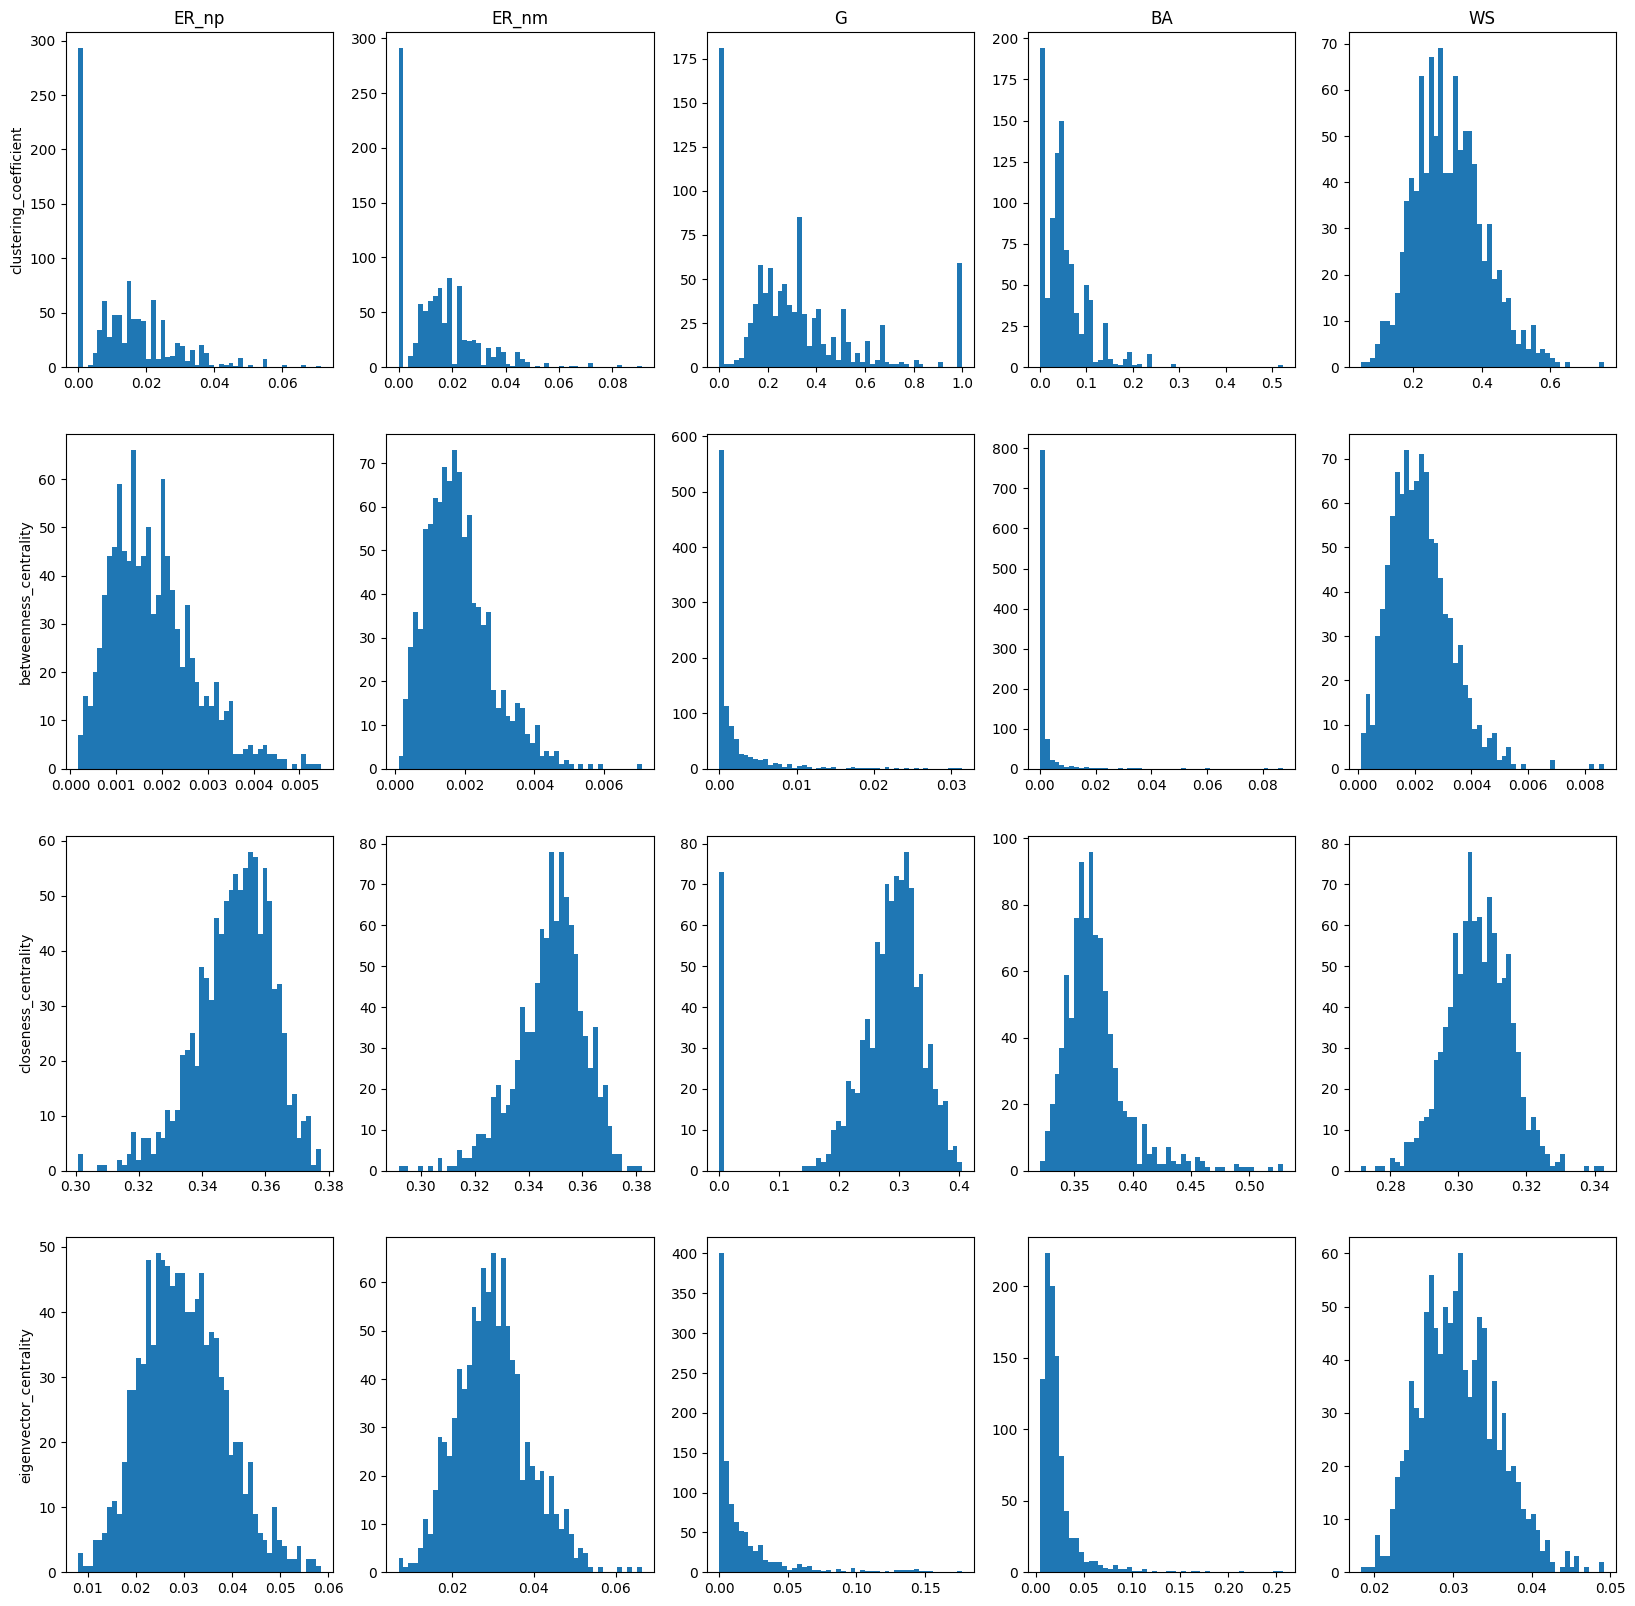

In [288]:
#draw the centrality distribution
fig, ax = plt.subplots(4,5, figsize=(20, 20))
#set line name and column name
column_name=['ER_np','ER_nm','G','BA','WS']
line_name=['clustering_coefficient','betweenness_centrality','closeness_centrality','eigenvector_centrality']
for i in range(4):
    for j in range(5):
        if i==0:
            ax[i,j].set_title(column_name[j])
        if j==0:
            ax[i,j].set_ylabel(line_name[i])
        ax[i,j].hist(eval(line_name[i]+'_'+column_name[j]).values(), bins=50)
plt.savefig('Result/RandomGraph/centrality_distribution_random.png',dpi=300)

## Question 4: Graph compression